In [1]:
import json
ds_train = json.load(open("training.json"))
ds_test = json.load(open("testing.json"))
imgs = ds_train["images"] + ds_test["images"]

# Classes for split

In [2]:
from tabulate import tabulate

pos_train = len([img for img in ds_train["images"] if img["is_candidate_location"]])
pos_test = len([img for img in ds_test["images"] if img["is_candidate_location"]])
neg_train = len([img for img in ds_train["images"] if not img["is_candidate_location"]])
neg_test = len([img for img in ds_test["images"] if not img["is_candidate_location"]])
print(tabulate([["", "Train", "Test", "Total"],
                ["Positives",
                 "{}({:.2f})".format(pos_train, pos_train * 100 /(pos_train+pos_test)),
                 "{}({:.2f})".format(pos_test, pos_test * 100 /(pos_train+pos_test)),
                 pos_train+pos_test],
                ["Negatives", 
                 "{}({:.2f})".format(neg_train, neg_train * 100 /(neg_train+neg_test)), 
                 "{}({:.2f})".format(neg_test, neg_test * 100 /(neg_train+neg_test)),
                 neg_train+neg_test]]))

---------  -----------  -----------  -----
           Train        Test         Total
Positives  2608(74.99)  870(25.01)   3478
Negatives  5221(75.06)  1735(24.94)  6956
---------  -----------  -----------  -----


In [3]:

fine_train = len([img for img in ds_train["images"] if img["valid_fine_grain"]])

fine_test = len([img for img in ds_test["images"] if  img["valid_fine_grain"]])

print(tabulate([["", "Train", "Test", "Total"],
                ["With fine grain labels",
                 "{}({:.2f})".format(fine_train, fine_train * 100 /(fine_train+fine_test)),
                 "{}({:.2f})".format(fine_test, fine_test * 100 /(fine_train+fine_test)),
                 fine_test+fine_train]]))

----------------------  ----------  ----------  -----
                        Train       Test        Total
With fine grain labels  547(76.50)  168(23.50)  715
----------------------  ----------  ----------  -----


# Labels per split

In [4]:
from collections import Counter

cat_training = []
for img in ds_train["images"]:
    cat_training.extend(img["categories"])
cat_training = Counter(cat_training)

cat_testing = []
for img in ds_test["images"]:
    cat_testing.extend(img["categories"])
cat_testing = Counter(cat_testing)

table = [["Label", "Images", "Train imgs", "Train(%)", "Test imgs", "Test(%)"]]
tot_train, tot_test = 0,0
for cat in ds_test["categories"]:
    train, test = cat_training[cat["id"]],cat_testing[cat["id"]]
    tot_train += train
    tot_test += test
    tot = train+test
    table.append([cat["name"], tot, train, "{:.2f}".format(train*100/tot), test, "{:.2f}".format(test*100/tot)])
tot = tot_train+tot_test
table.append(["TOTAL", tot, tot_train, "{:.2f}".format(tot_train*100/tot), test, "{:.2f}".format(tot_test*100/tot)])
    
print(tabulate(table))


--------------------------------------------  ------  ----------  --------  ---------  -------
Label                                         Images  Train imgs  Train(%)  Test imgs  Test(%)
Rubble/excavated earth and rocks              294     228         77.55     66         22.45
Bulky items                                   286     242         84.62     44         15.38
Fire Wood                                     173     135         78.03     38         21.97
Scrap                                         167     140         83.83     27         16.17
Plastic                                       126     102         80.95     24         19.05
Vehicles                                      53      27          50.94     26         49.06
Tires                                         45      32          71.11     13         28.89
Domestic appliances                           24      19          79.17     5          20.83
Paper                                         26      21          

# Segmentations per label

In [5]:
anns = [ann["category_id"] for ann in ds_test["annotations"]]
print("Images with annotations", len(set([ann["image_id"] for ann in ds_test["annotations"]])))
cat_anns_testing = Counter(anns)
counter = 0
table_anns = []
for cat in ds_test["categories"]:
    table_anns.append([cat["name"],cat_anns_testing[cat["id"]]])
    counter += cat_anns_testing[cat["id"]]
table_anns.append(["Total",counter])
print(tabulate(table_anns))

Images with annotations 169
--------------------------------------------  ---
Rubble/excavated earth and rocks              128
Bulky items                                    69
Fire Wood                                      63
Scrap                                           0
Plastic                                         0
Vehicles                                       70
Tires                                          36
Domestic appliances                             0
Paper                                           0
Sludge-Zootechnical waste-Manure                0
Foundry waste                                   0
Stone/marble processing waste                   0
Asphalt milling                                 0
Corrugated sheets (presumed asbestos-cement)    0
Glass                                           0
Heaps not delimited                           172
Full container                                188
Big bags                                       60
Full pallets          

# Positives properties

<Figure size 432x288 with 0 Axes>

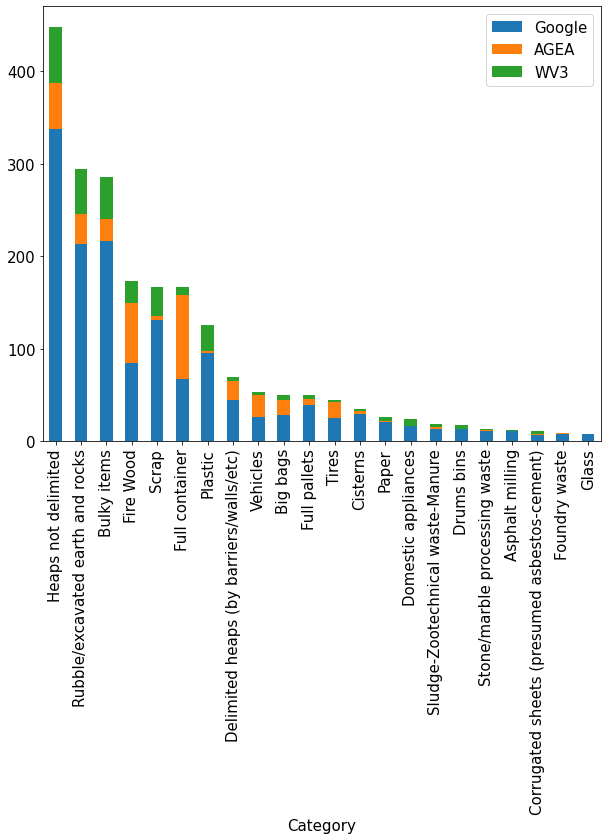

In [6]:
from collections import Counter, defaultdict
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

c_source = defaultdict(list)
c = []
for img in imgs:

    for cat in img["categories"]:
        c_source[cat].append(img["img_source"])
        
            
list_cat_source = []
for i in range(len(ds_test["categories"])):
    cc = Counter(c_source[i+1])
    o = cc["AGEA"] if "AGEA" in cc else 0
    g = cc["GE"] if "GE" in cc else 0
    w = cc["WV3"] if "WV3" in cc else 0
    list_cat_source.append((ds_test["categories"][i]["name"],  g,o, w))

list_cat_source.sort(key=lambda tup: sum([tup[1], tup[2], tup[3]]), reverse=True)  # sorts in place

plotdata = pd.DataFrame(list_cat_source, columns = ['Category',  "Google", "AGEA","WV3"])
plotdata = plotdata.set_index('Category')
plt.figure()
plt.rcParams.update({'font.size': 15}) # must set in top
plotdata.plot(kind="bar", stacked=True, figsize=(10,8))
plt.show()

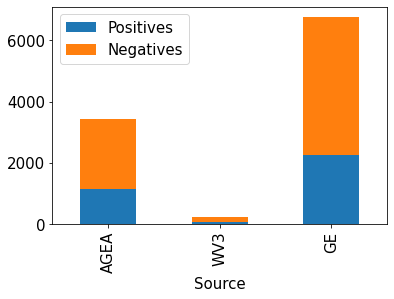

In [7]:
pos = Counter([img["img_source"] for img in imgs if img["is_candidate_location"]])
neg = Counter([img["img_source"] for img in imgs if not img["is_candidate_location"]])

ll = []
for key in pos.keys():
    ll.append((key, pos[key], neg[key]))
    
plotdata = pd.DataFrame(ll, columns = ['Source', "Positives", "Negatives"])
plotdata = plotdata.set_index('Source')
plotdata.plot(kind="bar", stacked=True)
plt.show()

/var/folders/7p/w85bsj110vldm1s1xjlm47gc0000gn/T/ipykernel_12643/1380239754.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = a[df[pname] == p]


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'Production site'),
  Text(1.5, 0, 'Degraded area'),
  Text(2.5, 0, 'Agricultural area/farm area'),
  Text(3.5, 0, 'Abandoned area'),
  Text(4.5, 0, 'Non production building'),
  Text(5.5, 0, 'Other'),
  Text(6.5, 0, 'n/s')])

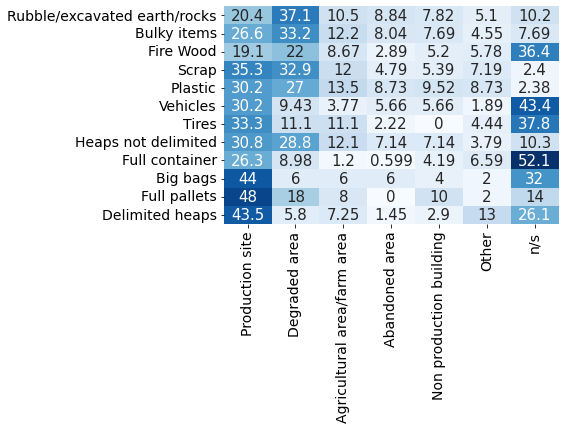

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt     
from collections import Counter

names = ['Rubble/excavated earth and rocks', 'Bulky items', 'Fire Wood', 'Scrap', 'Plastic', 'Vehicles', 'Tires', 'Heaps not delimited', 'Full container', 'Big bags', 'Full pallets', 'Delimited heaps (by barriers/walls/etc)' ]
names_display = ['Rubble/excavated earth/rocks', 'Bulky items', 'Fire Wood', 'Scrap', 'Plastic', 'Vehicles', 'Tires', 'Heaps not delimited', 'Full container', 'Big bags', 'Full pallets', 'Delimited heaps' ]
pname = "site_type"
propert = ['Production site','Degraded area', 'Agricultural area/farm area', 'Abandoned area', 'Non production building', 'Other','n/s']

ll = []
for img in imgs:
    if not "site_type" in img.keys():
        img["site_type"] = "n/s"
    if img["site_type"] == "Natural area" or img["site_type"] =='Public area' or img["site_type"] == 'Ecological pitch':
        img["site_type"] = "Other"
    
df = pd.DataFrame(imgs)
for sm in ds_test["categories"]:
    if not sm["name"] in names:
        continue
    lt = []
    for p in propert:
        a = df[(df['categories'].map(lambda x: sm["id"] in x))]
        b = a[df[pname] == p]
        lt.append(len(b))
        
    t = sum(lt)
    lt = list(map((lambda x: x/sum(lt)*100), lt))
    ll.append(lt)

ax = plt.subplot()
sns.heatmap(ll, annot=True, fmt='.3g', ax=ax, cbar=False, cmap="Blues")  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.yaxis.set_ticklabels(names_display, fontsize = 14)
ax.xaxis.set_ticklabels(propert, fontsize = 14)

plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

Text(0.5, 1.0, 'Distribution of severity among the positives')

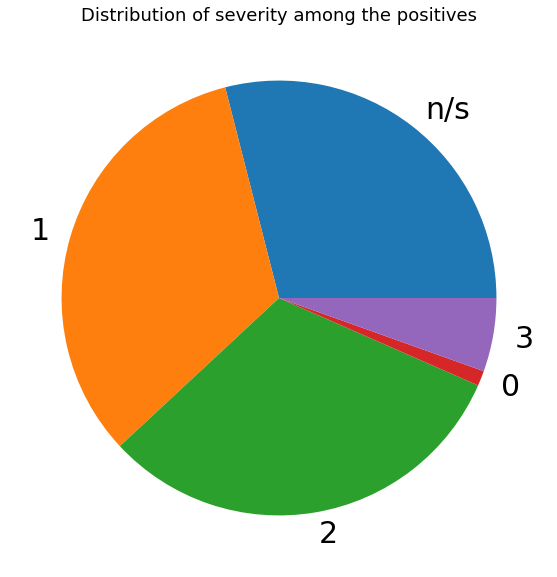

In [9]:
sev_count = Counter([img["severity"] for img in imgs if img["is_candidate_location"]])
plt.figure(figsize=(10,10))
plt.pie(sev_count.values(), labels = sev_count.keys(), #autopct='%1.1f%%',
        textprops={'fontsize': 30})

plt.title("Distribution of severity among the positives")

Text(0.5, 1.0, 'Distribution of evidence among the positives')

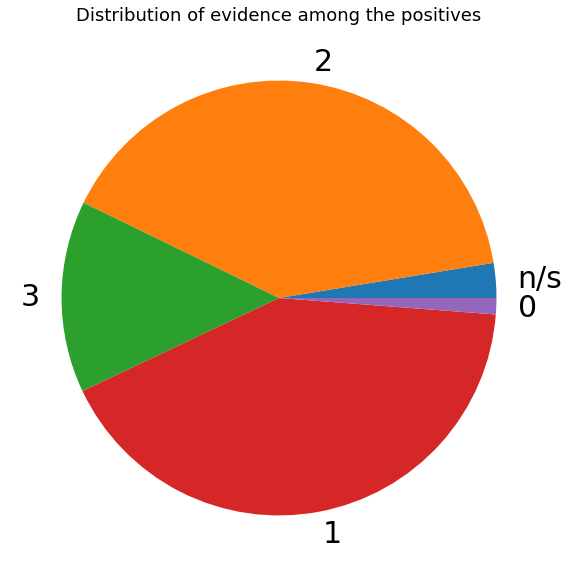

In [10]:
ev_count = Counter([img["evidence"] for img in imgs if img["is_candidate_location"]])
plt.figure(figsize=(10,10))
plt.pie(ev_count.values(), labels = ev_count.keys(), #autopct='%1.1f%%',
        textprops={'fontsize': 30})

plt.title("Distribution of evidence among the positives")